# Corner & Middle vs Sides

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

from utils import *
from calibrators import *

from sklearn.metrics import mean_squared_error, r2_score

## Functions

In [3]:
def group_data(
    df: pd.DataFrame,
    group_columns=[
        "username",
        "deviceName",
        "position",
        "distance",
        "targetPointX",
        "targetPointY",
    ],
) -> pd.DataFrame:
    # Columns to compute the median
    # Exclude group columns
    median_columns = [col for col in df.columns if col not in group_columns]

    # Grouping by specified columns and computing the median of the rest of the columns
    return df.groupby(group_columns)[median_columns].median().reset_index()

In [4]:
middle = (566.5, 372)
corners = [(0, 0), (0, 744), (1133, 0), (1133, 744)]
train_points = corners + [middle]


def create_split(
    calib_data: [CalibrationData],
) -> ([CalibrationData], [CalibrationData]):
    train_data = [data for data in calib_data if data.target_point in train_points]
    test_data = [data for data in calib_data if data.target_point not in train_points]
    return train_data, test_data

In [5]:
def get_features(
    data: CalibrationData,
    with_face_transfrom=False,
    with_right_eye_transfrom=False,
    with_roll_pitch_yaw=False,
    with_look_at_point=False,
) -> list:
    default_list = list(data.gaze_point)

    if with_face_transfrom:
        default_list.extend(data.face_transform.flatten())
    if with_right_eye_transfrom:
        default_list.extend(data.right_eye_transform.flatten())
    if with_roll_pitch_yaw:
        default_list.extend(data.euler_angles)
    if with_look_at_point:
        default_list.extend(data.look_at_point)

    return default_list

In [6]:
def train_and_evaluate(
    train_data: [CalibrationData],
    test_data: [CalibrationData],
    extract_features: callable,
):
    lrc = LinearRegressionCalibrator(train_data, extract_features)
    return lrc, lrc.evaluate(test_data)

In [7]:
def extract_features_from_row(
    row,
    with_face_transfrom=False,
    with_right_eye_transfrom=False,
    with_roll_pitch_yaw=False,
    with_look_at_point=False,
):
    default = list((row["gazePointX"], row["gazePointY"]))

    if with_face_transfrom:
        default.extend(extract_face_transform(row).flatten())
    if with_right_eye_transfrom:
        default.extend(extract_face_transform(row, type="rightEyeTransform").flatten())
    if with_roll_pitch_yaw:
        default.extend(extract_euler_angles_from_matrix(extract_face_transform(row)))
    if with_look_at_point:
        default.extend(list(row[["lookAtPointX", "lookAtPointY", "lookAtPointZ"]]))

    return default

In [8]:
def calibrate_df(
    model: LinearRegressionCalibrator,
    df: pd.DataFrame,
    extract_features_from_row: callable,
):
    new_columns = df.apply(
        lambda row: model.calibrate(extract_features_from_row(row)),
        axis=1,
        result_type="expand",
    )

    # Assign new column names to the resulting DataFrame
    new_columns.columns = ["calibratedPointX", "calibratedPointY"]

    return pd.concat([df, new_columns], axis=1)

## Setup

In [9]:
df = load_df("data")
print("Dataframe size:", df.shape)
display(df.head())

Dataframe size: (900, 63)


,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,229.150642,146.014301,0.999920,...,0.031501,0.030555,0.025464,1.0,-0.107358,-0.088746,0.935463,1.349115,-0.681568,0.239772
1,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.180792,145.479826,0.999916,...,0.031501,0.030555,0.025464,1.0,-0.107400,-0.088713,0.935594,1.330942,-0.702563,0.239077
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.020193,146.354776,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107197,-0.088691,0.935635,1.337107,-0.709690,0.248199
3,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.099802,146.935916,0.999912,...,0.031501,0.030555,0.025464,1.0,-0.107069,-0.088685,0.935711,1.337563,-0.713248,0.263629
4,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.052845,149.130141,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107005,-0.088807,0.935693,1.375624,-0.703335,0.269881


In [10]:
# show_subplots(df)

In [11]:
grouped_data = group_data(df)
print("Grouped dataframe size:", grouped_data.shape)
display(grouped_data.head())

Grouped dataframe size: (90, 63)


,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.031738,0.029988,0.024180,1.0,-0.207724,0.145160,0.870479,-19.190293,1.007004,-2.635080
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008,-10.586718,2.618074,-0.141696
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.032198,0.031979,0.023494,1.0,-0.197576,0.160285,0.890163,-12.971371,4.016960,0.998458
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844,-19.847600,-0.524636,-1.707931
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.032214,0.031813,0.023788,1.0,0.117347,0.118060,0.841723,-14.116672,2.550149,0.581315


In [12]:
calib_data = import_from_dataframe(grouped_data)
print(calib_data[0])

CalibrationData(username='victor', device_name='iPad Mini 6th', position=<HeadPosition.DOWN: 'Down'>, distance=<PositionToScreen.CLOSE: 'Close'>, timestamp=1715694344.8462515, target_point=(0.0, 0.0), gaze_point=(70.98875954512536, -324.5381952779969), face_transform=array([[ 0.9987874 ,  0.0376851 ,  0.03176365,  0.        ],
       [-0.0459676 ,  0.94369242,  0.32760049,  0.        ],
       [-0.01757462, -0.32865684,  0.94428898,  0.        ],
       [ 0.08613106, -0.05171058, -0.24211087,  1.0000001 ]]), right_eye_transform=array([[ 0.9790554 ,  0.02689365,  0.2018097 ,  0.        ],
       [ 0.        ,  0.9912371 , -0.13209465,  0.        ],
       [-0.20359376,  0.12932798,  0.97047603,  0.        ],
       [-0.03173006,  0.02996275,  0.02414582,  1.        ]]), left_eye_transform=array([[ 0.9622229 ,  0.03535037,  0.26995835,  0.        ],
       [ 0.        ,  0.99153507, -0.12983902,  0.        ],
       [-0.27226305,  0.12493407,  0.9540777 ,  0.        ],
       [ 0.0317378

In [13]:
# show_subplots(grouped_data)

In [14]:
# extract the target points and their gaze points
target_points = np.array([cd.target_point for cd in calib_data])
gaze_points = np.array([cd.gaze_point for cd in calib_data])

mse = mean_squared_error(target_points, gaze_points)
evaluation_without_calib = {
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2": r2_score(target_points, gaze_points),
}
print(evaluation_without_calib)

{'MSE': 337259.42011018266, 'RMSE': 580.7404068171791, 'R2': -1.7299477957842868}


Now we are going to create 10 different splits of train and test data.

In [15]:
nb_splits = 10
train_data, test_data = create_split(calib_data)

In [16]:
just_point = train_and_evaluate(train_data, test_data, lambda data: get_features(data))


face_transform = train_and_evaluate(
    train_data, test_data, lambda data: get_features(data, with_face_transfrom=True)
)

roll_pitch_yaw = train_and_evaluate(
    train_data, test_data, lambda data: get_features(data, with_roll_pitch_yaw=True)
)

face_and_rpy = train_and_evaluate(
    train_data,
    test_data,
    lambda data: get_features(data, with_face_transfrom=True, with_roll_pitch_yaw=True),
)

face_and_right_eye = train_and_evaluate(
    train_data,
    test_data,
    lambda data: get_features(
        data, with_face_transfrom=True, with_right_eye_transfrom=True
    ),
)

face_rpy_and_right_eye = train_and_evaluate(
    train_data,
    test_data,
    lambda data: get_features(
        data,
        with_face_transfrom=True,
        with_roll_pitch_yaw=True,
        with_right_eye_transfrom=True,
    ),
)

all_features = train_and_evaluate(
    train_data,
    test_data,
    lambda data: get_features(
        data,
        with_face_transfrom=True,
        with_roll_pitch_yaw=True,
        with_right_eye_transfrom=True,
        with_look_at_point=True,
    ),
)

In [17]:
# create dictionary with all the results
results = {
    "just_point": just_point,
    "face_transform": face_transform,
    "roll_pitch_yaw": roll_pitch_yaw,
    "face_and_rpy": face_and_rpy,
    "face_and_right_eye": face_and_right_eye,
    "face_rpy_and_right_eye": face_rpy_and_right_eye,
    "all_features": all_features,
}

In [18]:
print(results)

{'just_point': (<calibrators.linear_regression_calibrator.LinearRegressionCalibrator object at 0x7f8e51553080>, {'MSE': 74110.06065116855, 'RMSE': 272.23163051190164, 'R2': 0.2802415525567359}), 'face_transform': (<calibrators.linear_regression_calibrator.LinearRegressionCalibrator object at 0x7f8e51f37ad0>, {'MSE': 29873.88766000908, 'RMSE': 172.84064238485428, 'R2': 0.7390043043286779}), 'roll_pitch_yaw': (<calibrators.linear_regression_calibrator.LinearRegressionCalibrator object at 0x7f8e52f174d0>, {'MSE': 30897.944014455912, 'RMSE': 175.7781101686325, 'R2': 0.6871258129939344}), 'face_and_rpy': (<calibrators.linear_regression_calibrator.LinearRegressionCalibrator object at 0x7f8e51552870>, {'MSE': 32106.898559743204, 'RMSE': 179.18397964032164, 'R2': 0.7117828536732127}), 'face_and_right_eye': (<calibrators.linear_regression_calibrator.LinearRegressionCalibrator object at 0x7f8e51595970>, {'MSE': 34983.03432041305, 'RMSE': 187.03752115661993, 'R2': 0.702444743019634}), 'face_rpy_a

In [19]:
# for each result, compute median and std of the RMSE and R2
summary = {
    name: {
        "rmse": result["RMSE"],
        "r2": result["R2"],
    }
    for name, (_, result) in results.items()
}

In [20]:
for name, s in summary.items():
    print(f"{name:25}: RMSE={s['rmse']:.2f}, R2={s['r2']:.2f}")

just_point               : RMSE=272.23, R2=0.28
face_transform           : RMSE=172.84, R2=0.74
roll_pitch_yaw           : RMSE=175.78, R2=0.69
face_and_rpy             : RMSE=179.18, R2=0.71
face_and_right_eye       : RMSE=187.04, R2=0.70
face_rpy_and_right_eye   : RMSE=168.71, R2=0.73
all_features             : RMSE=190.34, R2=0.69


In [21]:
names = list(summary.keys())


def create_plot(metric, values):
    # Creating the bar plot with error bars
    plt.figure(figsize=(15, 10))
    plt.bar(names, values, capsize=5, color="blue", alpha=0.7)
    plt.xlabel("Model Name")
    plt.ylabel(metric)
    plt.title(f"{metric} with Standard Deviation for Each Model")
    plt.show()

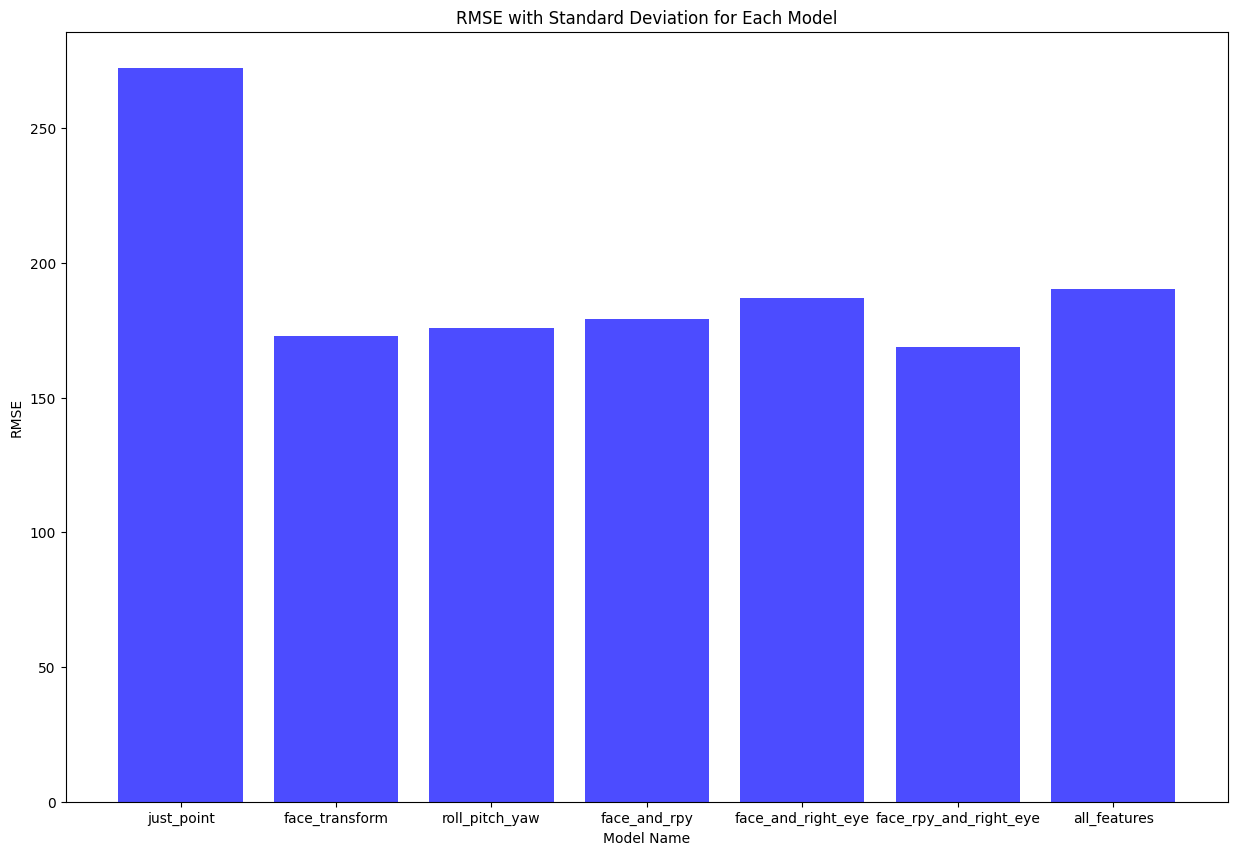

In [22]:
rmse_values = [s["rmse"] for s in summary.values()]

create_plot("RMSE", rmse_values)

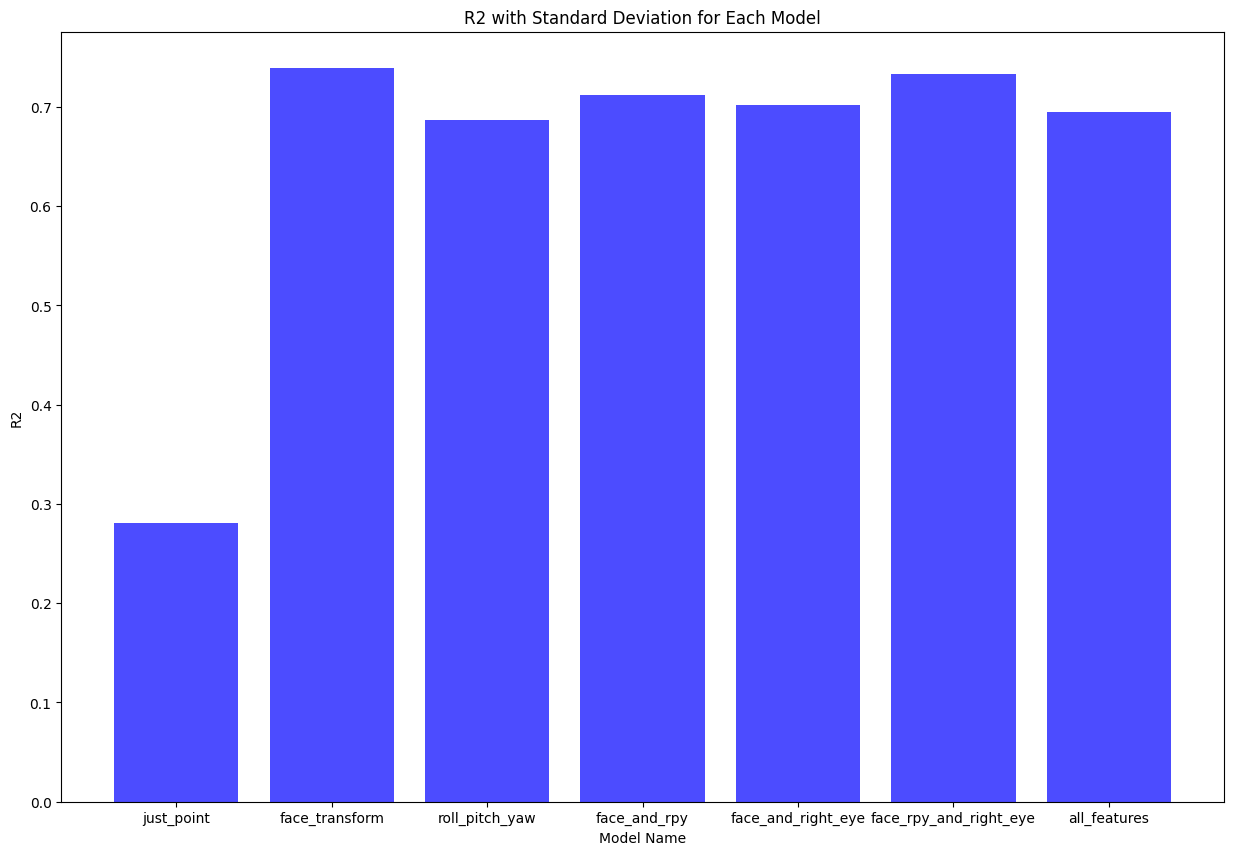

In [23]:
r2_values = [s["r2"] for s in summary.values()]

create_plot("R2", r2_values)

Model with lowest RMSE: face_rpy_and_right_eye
Best RMSE: 168.71
With R2: 0.69


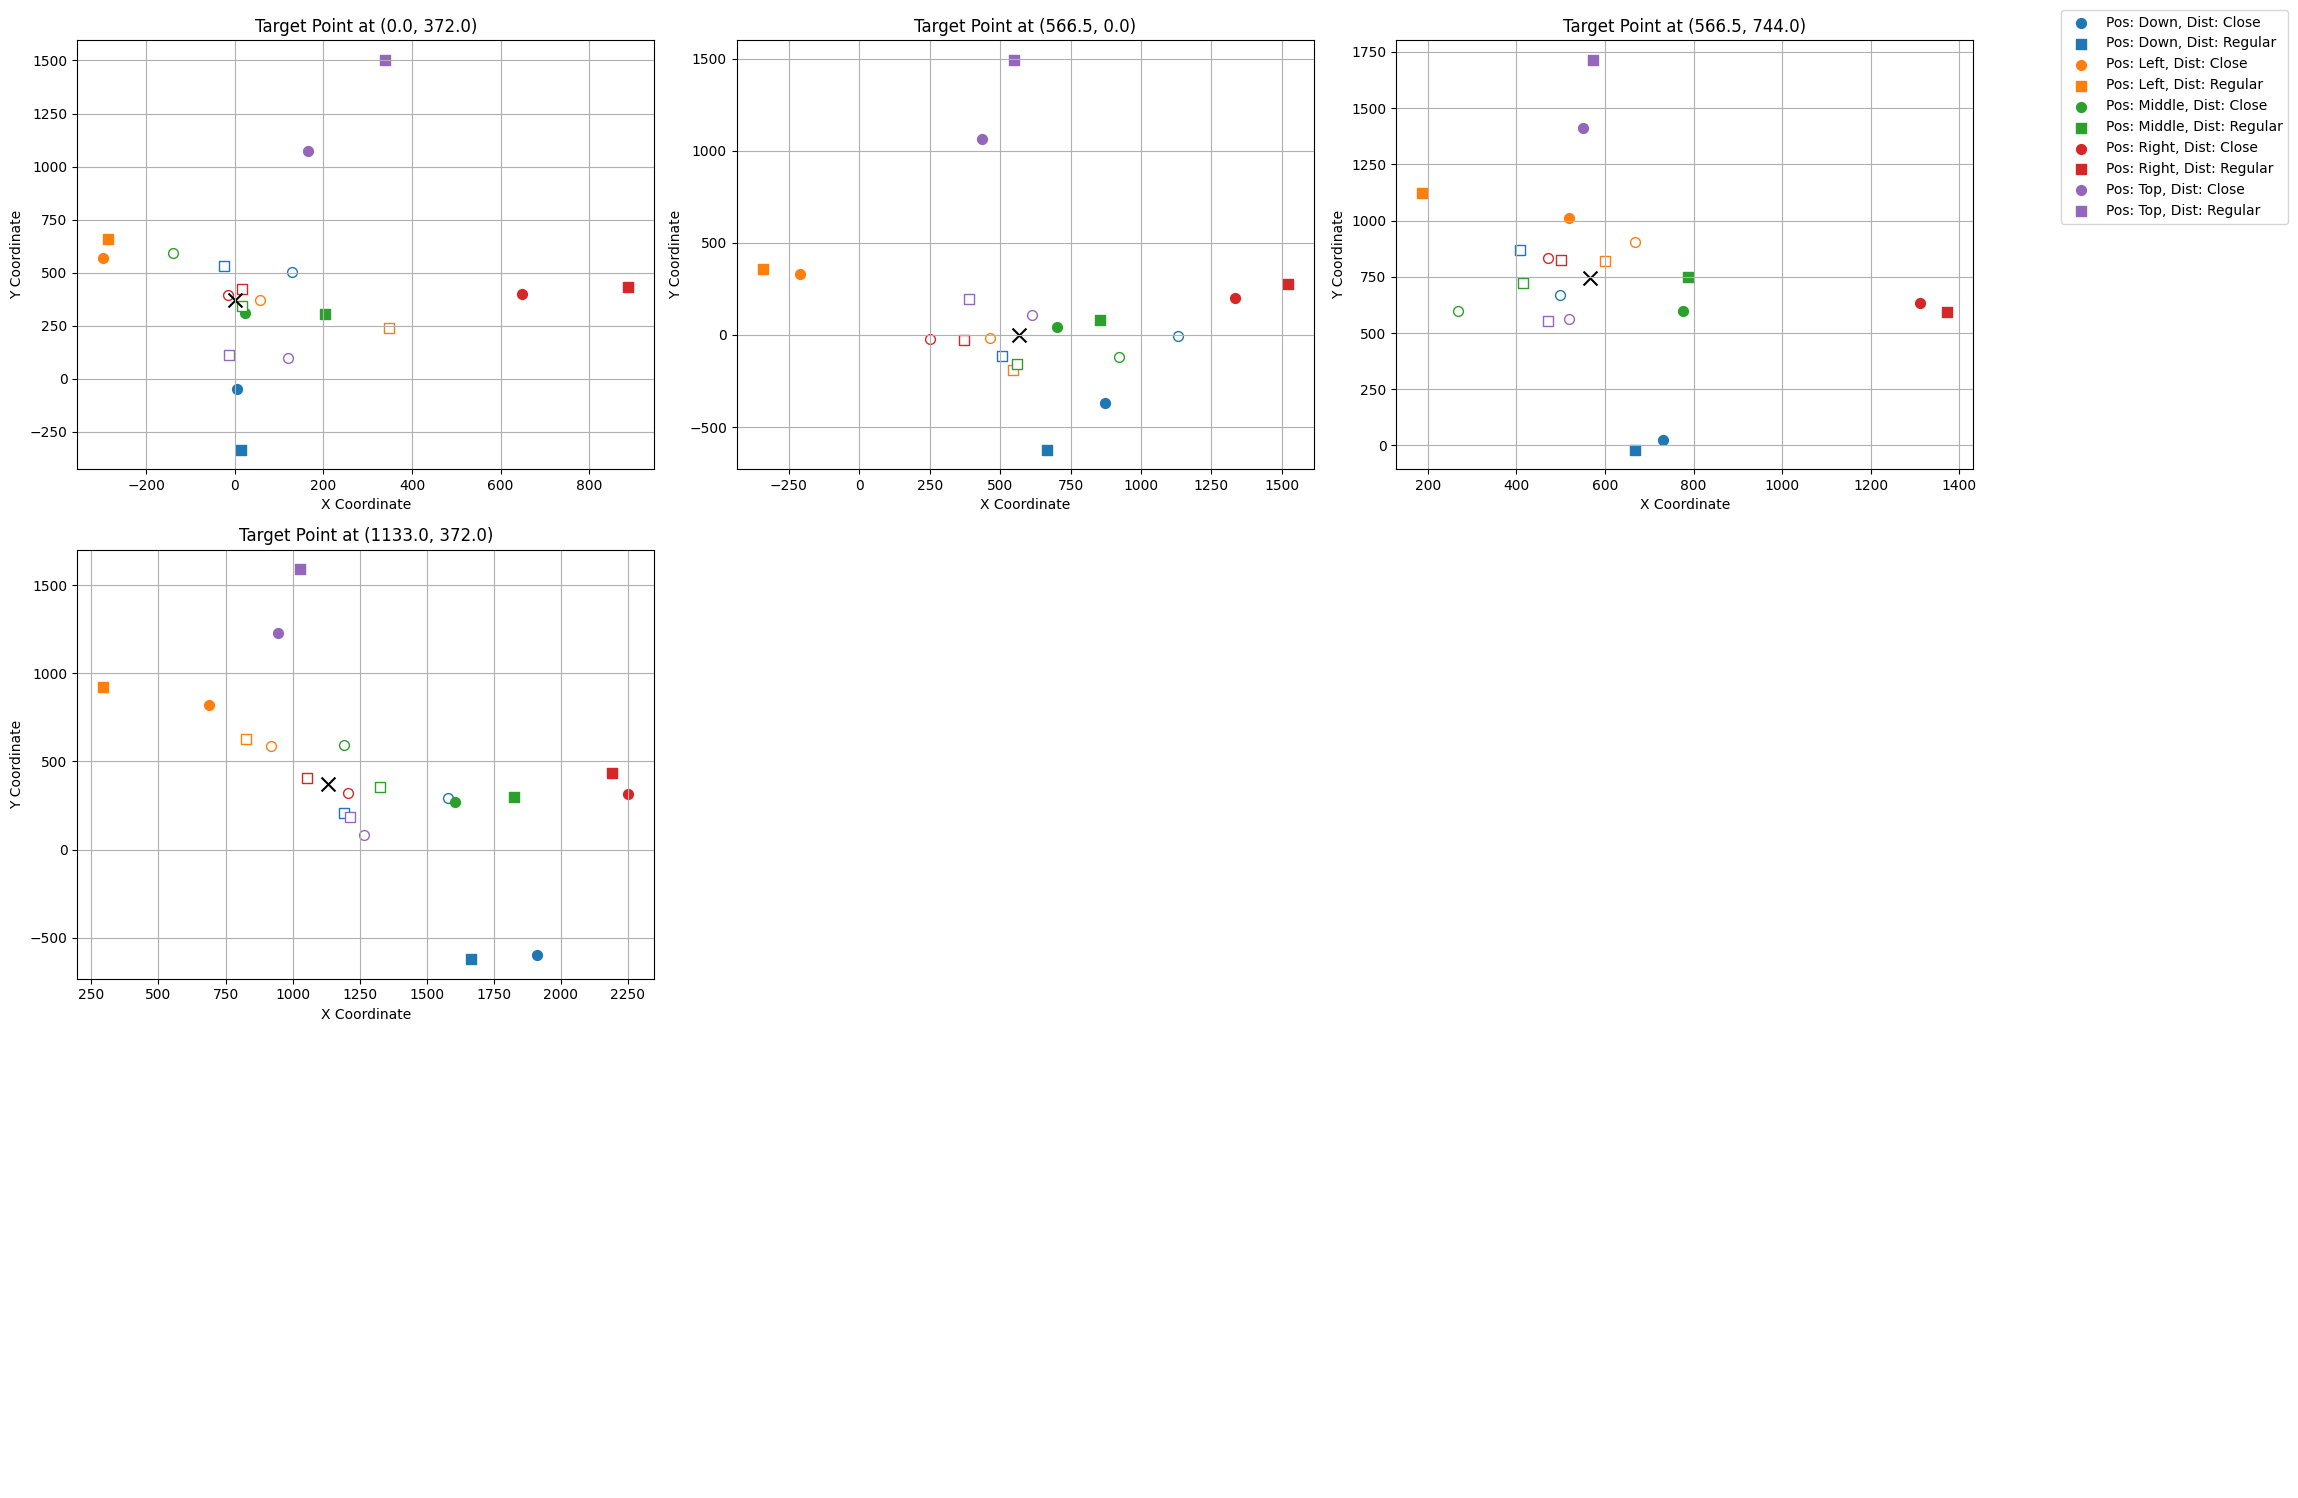

In [24]:
# Find the one with the best RMSE
name = ""
lrc = None
best_rmse = float("inf")
for name_, result in results.items():
    model, evaluation = result
    if evaluation["RMSE"] < best_rmse:
        best_rmse = evaluation["RMSE"]
        lrc = model
        name = name_

print(f"Model with lowest RMSE: {name}")
print(f"Best RMSE: {best_rmse:.2f}")
print(f"With R2: {evaluation['R2']:.2f}")
test_df = calib_data_to_dataframe(test_data)

calibrated_df = calibrate_df(
    lrc,
    test_df,
    lambda row: extract_features_from_row(
        row,
        with_face_transfrom=True,
        with_roll_pitch_yaw=True,
        with_right_eye_transfrom=True,
    ),
)

show_subplots(calibrated_df, with_calib=True)